In [27]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [28]:
train=pd.read_csv("./churn_prediction_data/train.csv")
test=pd.read_csv("./churn_prediction_data/test.csv")

In [29]:
train["Exited"].value_counts()

0    6368
1    1632
Name: Exited, dtype: int64

## 資料前處理

In [410]:
#ID取前四個數字
train["ID"]=train['CustomerId'].astype(str).str[:5].astype(int)
#將財務商品整合成兩類，大於2個、少於等於2個
train["is_4"]=train['NumOfProducts'].apply(lambda x: 1 if x >2  else 0)
#性別數值化(男生0、女生1)
train['Gender']=train['Gender'].apply(lambda x: 1 if x =="male"  else 0)
train["greater than 70000"]=train["Balance"].apply(lambda x: 1 if x >70000  else 0)

In [411]:
#將名字數值化
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train['Surname'].append(test['Surname']))
train["NAME_ID"]=pd.Series(le.transform(train['Surname']))

In [412]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(train[["Balance","EstimatedSalary"]])
#train["money"] = pca.transform(train[["Balance","EstimatedSalary"]])

PCA(n_components=1)

In [413]:
moneys=pd.DataFrame(pca.transform(train[["Balance","EstimatedSalary"]]),columns=['money1'])
#moneys=pd.DataFrame(pca.transform(train[["Balance","EstimatedSalary"]]),columns=['money1', 'money2'])

In [414]:
#選擇重要的特徵
select_data=train[["CreditScore","Balance","Tenure","Gender","IsActiveMember",'Age','NumOfProducts']]

In [415]:
#國家dummy variable
features_dummies=pd.get_dummies(train["Geography"])

In [416]:
#合併資料
#data=select_data
data=pd.concat([select_data, features_dummies],axis=1)

In [417]:
data

,CreditScore,Balance,Tenure,Gender,IsActiveMember,Age,NumOfProducts,France,Germany,Spain
0,720,114051.97,5,0,1,38,2,0,0,1
1,682,62397.41,4,0,0,54,1,1,0,0
2,672,119903.67,5,0,1,31,1,1,0,0
3,592,104257.86,4,0,0,40,1,0,0,1
4,753,120387.73,5,0,1,42,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
7995,568,121079.60,6,0,1,35,2,1,0,0
7996,602,145846.07,7,0,0,45,1,0,1,0
7997,679,132810.01,5,0,0,43,1,0,0,1
7998,715,118729.45,4,0,0,38,1,1,0,0


## 切訓練集/測試集

In [806]:
#切割資料
train_data,test_data,train_labels,test_labels=train_test_split(data,train["Exited"],test_size=0.05)

In [807]:
train_labels = np.array(train_labels)
train_data =  np.array(train_data)
test_labels= np.array(test_labels)
test_data = np.array(test_data)

## 處理資料不平衡

In [808]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
train_data, train_labels = sm.fit_resample(train_data, train_labels)

## 利用GradientBoostingClassifier

In [809]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(train_data,train_labels)

GradientBoostingClassifier()

In [810]:
gbc.score(train_data,train_labels)

0.9117647058823529

In [811]:
gbc.score(test_data,test_labels)

0.875

<Figure size 432x288 with 0 Axes>

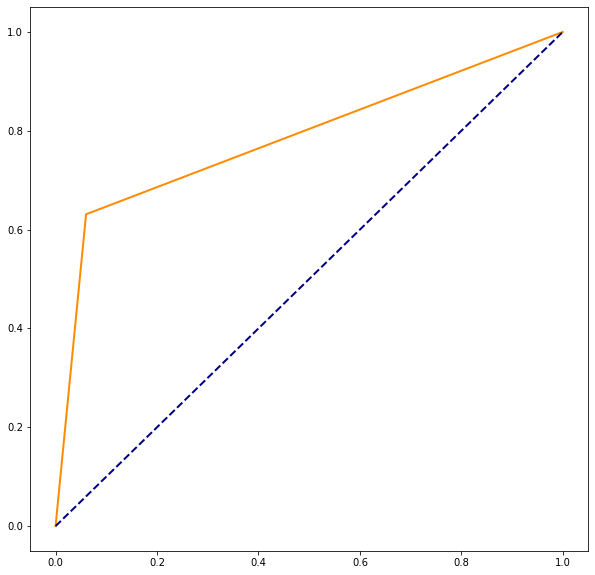

In [812]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr,tpr,threshold =roc_curve(test_labels, gbc.predict(test_data))
roc_auc = auc(fpr,tpr) ###計算auc的值 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.show()

In [813]:
roc_auc

0.7854128993369499

## 挑最佳參數

In [17]:
from sklearn.model_selection import KFold,StratifiedKFold,ShuffleSplit
cv=StratifiedKFold(n_splits=5)
cv1=KFold(n_splits=5)
cv2=ShuffleSplit(n_splits=5,test_size=0.2)

In [19]:
from sklearn.model_selection import cross_val_score
scores =cross_val_score(gbc,data,train["Exited"],cv=cv,scoring='accuracy')
print(scores.mean())

0.86425


## test資料預測

In [814]:
#test資料前處理
test["ID"]=test['CustomerId'].astype(str).str[:4].astype(int)
test["is_4"]=test['NumOfProducts'].apply(lambda x: 1 if x >2  else 0)
test["NAME_ID"]=pd.Series(le.transform(test['Surname']))
test['Gender']=test['Gender'].apply(lambda x: 1 if x =="male"  else 0)
test["greater than 70000"]=test["Balance"].apply(lambda x: 1 if x >70000  else 0)

In [815]:
#PCA轉換
moneys_1=pd.DataFrame(pca.transform(test[["Balance","EstimatedSalary"]]),columns=['money1'])
#moneys_1=pd.DataFrame(pca.transform(test[["Balance","EstimatedSalary"]]),columns=['money1', 'money2'])

In [816]:
#特徵選擇
select_data=test[["CreditScore","Balance","Tenure","Gender","IsActiveMember",'Age','NumOfProducts']]

In [817]:
#特徵dummy
features_dummies=pd.get_dummies(test["Geography"])

In [818]:
#合併資料
data=pd.concat([select_data, features_dummies],axis=1)

In [819]:
#預測結果
gbc.predict(data)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [820]:
#預測為1的比例
sum(gbc.predict(data)>roc_auc)/2000

0.16

## 匯出資料

In [821]:
#GradientBoostingClassifier
d = {"RowNumber":test.RowNumber,"Exited":gbc.predict(data)}
df = pd.DataFrame(d)
df.to_csv("./output/gbc6.csv")